## To run: Simply run all cells.  The last 2 cells call the fuctions. See those cells for information about picking audio inputs and soundfonts. ##

In [2]:
import IPython, numpy as np, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math, scipy as sp
from IPython.display import Audio
from IPython.display import HTML
 
# setup thangssss

# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

def apply_style():
    """
    Useful styles for displaying graphs and audio elements.
    """
    style = HTML("""
        <style>
            audio {
            width: 100% !important;
        }
        .output_png {
            text-align: center !important;
        }
        </style>
        """)
    IPython.display.display(style)
    
def audio(d, sr, ext = '.mp3'):
    """
    Embeds audio into notebook
    Parameters:
       d: numpy array of audio data.
       sr: sampling rate for the audio
    """
    IPython.display.display(IPython.display.Audio(data=d, rate = sr))
    
apply_style()

In [3]:
# a classic
def plot_audio(x, sr, figsize=(16,4)):
    """
    A simple audio plotting function
    
    Parameters
    ----------
    x: np.ndarray
        Audio signal to plot
    sr: int
        Sample rate
    figsize: tuple
        A duple representing the figure size (xdim,ydim)
    """
    length = float(x.shape[0]) / sr
    t = np.linspace(0,length,x.shape[0])
    plt.figure(figsize=figsize)
    plt.plot(t, x)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.show()
    
    
def make_sinewave(f, t, sr):
    """    
    Parameters
    ----------
    f:  float
        Frequency of sine wave
    t:  float
        Duration in seconds
    sr: int
        Sample rate
    
    Returns
    -------
    np.ndarray 
        Array of floats containing the signal
    """
    
    x = np.linspace(0.0, float(t), num=(float(sr)*float(t)))
    return np.sin(np.multiply(2.0*math.pi*float(f), x))
    

In [4]:
def make_triangular_filters(cfreqs,freqs,nyquist):
    """
    Computes a set of "filters" to apply to an STFT to change its frequency scaling.
    This takes an array of center frequencies (cfreqs) and a set of frequencies of 
    analysis from your Fourier transform (freqs) as input, both coded in Hz.  It will 
    return a 2-D numpy array filters[c][f], where c is the index number of a center 
    frequency in cfreqs and f is the index to a frequency in freqs and the value in 
    filters[c][f] gives the filter magnitude (a number between 0 and 1 that represents 
    how sensitive this filter is to that frequency). 
    
    Filters are triangular, with a linear decrease in sensitivity from the center 
    frequency (sensitivity = 1) down to a sensitivity of 0 by the center frequency 
    of each adjacent freqency. The lowest center frequency will decrease to 0 by 
    0 Hz on the low end. The highest center frequency will decrease to 0 by the 
    Nyquist frequency on the high end.
    
    Note: you do not have to normalize the filters by energy in this exercise 
    (the maximum magnitude for all filters is equal to 1).
    
    Input Parameters
    ----------------
    cfreqs: a 1-D python array of center frequencies measured in Hz
    freqs:   a 1-D python array of frequencies for whom we need to calculate the sensitivity
             of each filter (also measured in Hz)
    nyquist: the frequency of the nyquist rate. By default, the filter with the highest 
            center frequency will have its response reach 0 at the nyquist frequency. 
    
    Returns
    -------
    filters: a 2-D numpy array, where c is the index number of a center frequency in 
            cfreqs and f is the index to a frequency in freqs and the value in filters[c][f] 
            is a number between 0 and 1 that represents how sensitive this filter is to 
            that frequency.
            
    """
     
    assert min(freqs)<=min(cfreqs) and max(freqs)>=max(cfreqs), "cfreqs range must be within freqs range."

    filters = np.zeros((len(cfreqs), len(freqs)))
        
    for c in range(0,len(cfreqs)):
        if c==0: 
            # if we're on the first cfreq, use 0 for the low frequency
            low_freq = 0 
            high_freq = cfreqs[c+1]
        elif c==(len(cfreqs)-1):
            # if we're on the last cfreq, use nyquist for the high frequency
            low_freq = cfreqs[c-1]
            high_freq = nyquist 
        else:
            low_freq = cfreqs[c-1]
            high_freq = cfreqs[c+1]
  
        for f in range(len(freqs)):
            
            if (freqs[f]> cfreqs[c]):
                x = freqs[f]
                b = -high_freq / float(cfreqs[c]-high_freq) # offset
                a = 1./(cfreqs[c]-high_freq) # slope
                filters[c][f] = max([a*x+b,0.])
                    
            elif (freqs[f]< cfreqs[c]):
                x = freqs[f]
                b = -low_freq / float(cfreqs[c]-low_freq) # offset
                a = 1./(cfreqs[c]-low_freq) # slope
                filters[c][f] = max([a*x+b,0.])
            else:
                filters[c][f] = 1.0
    return filters



def makePitchFilters(freqs):
    cfreaks = 27.5*2**(np.arange(-1.0, 89.0)/12.0)
    filts = make_triangular_filters(cfreaks,freqs,cfreaks[89] + 1.0)
    return filts[1:89, :]
    
def binSTFT(sr, stftres):
    print(stftres.shape)
    freaks = librosa.fft_frequencies(sr, stftres.shape[0])
    filts = makePitchFilters(freaks)
    stftres = stftres[0:len(freaks)]
    binnedstft = np.zeros((88, stftres.shape[1]))
    for i in range(0, 88):
        for j in range(0, stftres.shape[1]):
            binnedstft[i, j] = np.sum(np.multiply(filts[i, :], stftres[:, j].T))
            
    return binnedstft
    
    

In [5]:
import paulstretch_samples as pstretch
import fluidsynth
import pyaudio

# get first ___ seconds of audio
def clipAudio(aud, sec, sr):
    clip = np.zeros(sec * sr)
    clip = aud[0 : sec*sr]
    return clip


In [6]:
# calculating the velocity per value (later used in fluidsynth)
def calcVel(v, th, maxV):
    if v<th:
        return 0
    return (v-th)/(maxV-th)*127.0

# apply calcVel to entire array (cqt)
def cqt2vel(cqt, threshold):
    maxV = cqt.max()
    th = maxV*threshold
    vFunc = np.vectorize(calcVel)
    return vFunc(cqt, th, maxV)

In [7]:
# PYFLUIDSYNTH MAGIC

# import time
# import numpy
# import pyaudio
# import fluidsynth

In [8]:
                # # # # # # # # # # # # # # # # # #
                # * # * # * MIDI  MAGIC * # * # * # 
                # # # # # # # # # # # # # # # # # # 

def cqt2midi(synth, soundfont, cqt, threshold, sr, hop_size):
    
    # initialize
    # synth = fluidsynth.Synth()
    # sfid = fl.sfload("soundfonts/Yoshi's Island.sf2")
    sfid = synth.sfload(soundfont)

    # use cqt2vel --> matrix of val (0, 127)
    clipqt_vel = cqt2vel(cqt, threshold) # clipped_cqt, threshold e.g. 0.2
    
    vmask = np.zeros(clipqt_vel.shape)
    
    for i in range(0,88):
        vmask[i, :] = 1.0*(float(i))/88.0 + -0.2*(88.0-float(i))/88.0
        if vmask[i, 0] < 0 :
            vmask[i, :] = 0
        
    clipqt_vel = np.multiply(vmask, clipqt_vel)
    
    
    plt.pcolormesh(clipqt_vel)
    plt.title("Calulated Velocity from CQT Log Amplitude")
    plt.ylabel("Piano Key")
    plt.xlabel("CQT Frame")
    plt.show()
    
    

    # make 88 channels in fluidsynth (for 88 keys)
    for i in range(0, 88):
        synth.program_select(i, sfid, 0, 0)

    # at beg - noteon for every channel at vel 127
    for i in range(0, 88):
        synth.noteon(i, i+33, 127)

    # for every channel -- control (___.cc) -- set volume to 0
    for i in range(0, 88):
        synth.cc(i, 7, 0) # 7 --> volume

    # for every col in vel result -- each row is the key (channel) - val is the velocity
    # use cc to set the channel's velocity
    samps = np.zeros(cqt.shape[1]*hop_size)
    start = 0
    
#     for i in range(0, cqt.shape[1]): # each time frame
    for i in range(0, cqt.shape[1]): # each time frame
        for j in range(0, 88): # each bin/key
            synth.cc(j, 7, int(clipqt_vel[j, i]))

        samps[start: start + hop_size] = synth.get_samples(int(hop_size/2))
        start += hop_size
    
    print len(samps)
    return np.array(samps)

In [9]:
def cross_sim_matrix(feature_vectors_a, feature_vectors_b, sample_rate, hop_length, distance_metric = 'cosine', display = True):
    """
        Input:
            feature_vectors_a - a numpy ndarray MxN, where M is the number of features in each vector and 
            N is the length of the sequence. Corresponds to the reference song.
            feature_vectors_b - a numpy ndarray MxN, where M is the number of features in each vector and 
            N is the length of the sequence. Corresponds to the cover song.
            sample_rate - sample rate of the original audio
            hop_length - how many samples are in each frame
            distance_metric - which distance metric to use to compute similarity. Defaults to cosine.
            display - whether or not to display the similarity matrix after computing it. Defaults to True.
        Output:
            if display is True, plot the similarity matrix. Along the x and y axis of the similarity matrix, 
            the ticks should be in seconds not in samples. 
            returns cross_sim_matrix - an NxN matrix with the pairwise distance between every feature vector.
    """
    
    D = (sp.spatial.distance.cdist(feature_vectors_a.T, feature_vectors_b.T, metric = distance_metric))
    Dmax = D.max()
    s_matrix = np.subtract(1.0, (D/Dmax))
    if display:
        plt.figure()
        plt.imshow(s_matrix)
        skip = feature_vectors_a.shape[-1] / 10
        plt.xticks(np.arange(0, feature_vectors_a.shape[-1], skip),
                               ['%.2f' % (i * hop_length / float(sample_rate)) for i in range(feature_vectors_a.shape[-1])][::skip],
                  rotation='vertical')
        plt.yticks(np.arange(0, feature_vectors_b.shape[-1], skip),
                               ['%.2f' % (i * hop_length / float(sample_rate)) for i in range(feature_vectors_b.shape[-1])][::skip])
        plt.xlabel('Time (s)')
        plt.ylabel('Time (s)')
        plt.title('Cross Similarity matrix')
        
    return s_matrix

In [10]:
def foundMain(wavfile, s2f, clipLength = 5, hopSize = 2048):
    (sr, wav) = pstretch.load_wav(wavfile)

    # cut off after 5 sec
    clipped = clipAudio(wav, clipLength, sr)
    
    audio(clipped, sr)

    # slow down by 10 times - get samples
    sl = pstretch.paulstretch(sr, clipped, 10, .125)

    clipped_cqt = librosa.logamplitude(np.abs(librosa.cqt(sl, sr=sr, hop_length=hopSize, real=False, n_bins=88, bins_per_octave=12, fmin=27.5)))  

    # plot that thanggg
    plt.pcolormesh(clipped_cqt)
    plt.title("CQT Log Amplitude of Slowed Down Input")
    plt.ylabel("Piano Key")
    plt.xlabel("CQT Frame")
    plt.show()

    # plot_audio(sl, sr)

    audio(sl, sr)
    
    test_midi = cqt2midi(fluidsynth.Synth(), s2f, clipped_cqt, 0.3, 44100, 2048)

    midi_cqt = librosa.logamplitude(np.abs(librosa.cqt(test_midi, sr=sr, hop_length=2048, real=False, n_bins=88, fmin=27.5)))    
    

    # plot that thanggg
    plt.pcolormesh(midi_cqt)
    plt.title("CQT Log Amplitude of MIDI Creation")
    plt.ylabel("Piano Key")
    plt.xlabel("CQT Frame")
    plt.show()
    
    audio(test_midi, sr)
    
    clipped_cqt = (clipped_cqt)/clipped_cqt.max()
    midi_cqt = (midi_cqt)/midi_cqt.max()

    csm = cross_sim_matrix(clipped_cqt, midi_cqt, sr, 2048, distance_metric = 'cityblock', display = True)
    
    return test_midi

In [11]:
def foundPlayback(speed, midiAud, sr):
    spedup = pstretch.paulstretch(sr, midiAud, (1.0/float(speed)), .125)
    audio(spedup, sr)

# Select input audio, soundfont, and length of the clip #

100 %


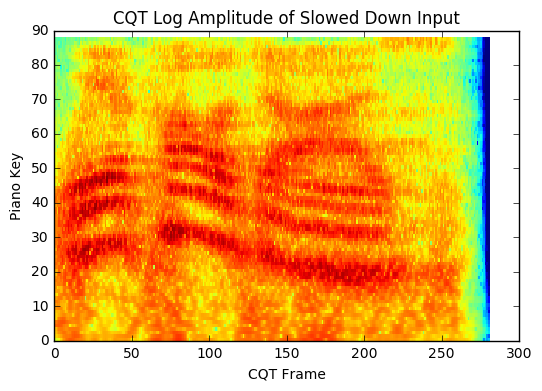

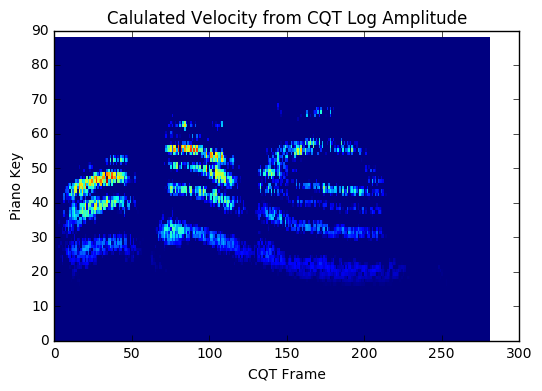

575488


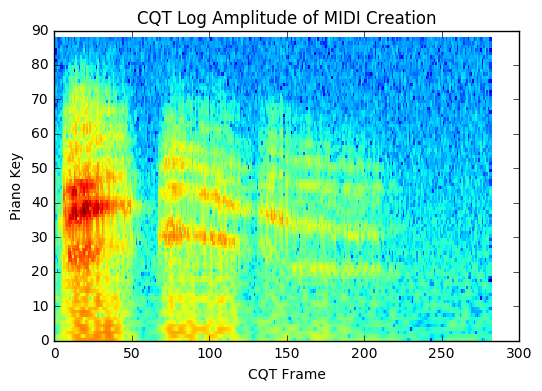

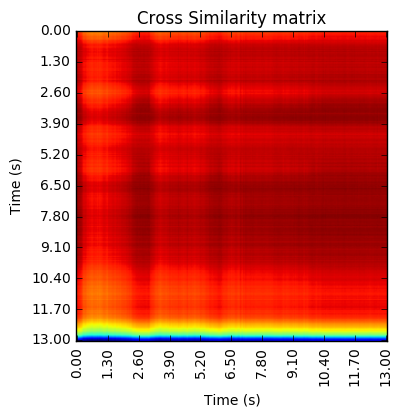

In [19]:
### There are a few included audio files and sound fonts that can be used, but other files may also be used ###
# To change input files, change the first argument to the path of the audio input
# To change instruments, change the second argument to the path of the soundfont


### These are the included audio files that can be used: ###
# audio/wrigley.wav 
# audio/snickers1.wav
# audio/snickers2.wav
# audio/snickers3.wav
# audio/skittles.wav
# audio/we-apologize.wav

### These are the included soundfonts that can be used: ###
# soundfonts/052_Florestan_Ahh_Choir.sf2
# soundfonts/sine.sf2
# soundfonts/Fantstrn.sf2
# soundfonts/mustheory2.sf2
# soundfonts/Viopiz2.sf2
# soundfonts/Yoshi's Island.sf2

# # # # # # # # # # # # # # # # # # 

# pick an input audio, a sound font, and how long the clip will be
midiAud = foundMain("audio/we-apologize.wav", "soundfonts/mustheory2.sf2", clipLength=5)


# Select playback speed of the final result! #

In [20]:
# select playback speed -- 10.0 is the speed of the original input
foundPlayback(10.0, midiAud, 44100)

100 %
